---
title: Hicks-Henne Bump Functions
subtitle: Theory to Practice - A Tutorial on Hicks-Henne Bump Functions.
date: 2025-09-27
bibliography:
  - references.bib
---

Hicks-Henne bump function representation is a classical approach for parameterizing airfoil and wing
shapes. It uses two families of bump functions[^bump_function], which are added linearly onto a
baseline geometry to produce a modified shape. In this tutorial, we walk through the theory behind
Hicks-Henne bump functions and how to actually use their `geodiff` implementation in practice.

[^bump_function]:
    > In mathematical analysis, a bump function (also called a test function) is a function
    > $f: \mathbb{R}^{n} \rightarrow \mathbb{R}$ on a Euclidean space $\mathbb{R}^{n}$ which is both
    > smooth (in the sense of having continuous derivates of all orders) and compactly supported.
    > 
    > -- [Wikipedia, Bump function](https://en.wikipedia.org/wiki/Bump_function)

    In simpler terms, a bump function has derivatives of all orders and is only non-zero on a finite
    region, meaning it is "localized" and only modifies the shape within a specific interval.


:::{note} History behind the Hicks-Henne bump functions
:class: dropdown
The Hicks-Henne bump function parameterization was popularized by the paper titled "Wing design by
numerical optimization" [@hicks1978wing]. Almost all references to the Hicks-Henne parameterization
point to this paper. But, this paper does not list the functional form of the Hicks-Henne basis
functions. These were introduced in a prior paper "Application of Numerical Optimization to the
Design of Supercritical Airfoils without Drag-Creep." [@hicks1977application]. So the actual basis
functions were used by Hicks and Vanderplaats but the name Hicks-Henne has stuck since their paper
popularized it.
:::

In [1]:
# Basic Imports
import matplotlib.pyplot as plt
import torch

from geodiff.hicks_henne import HicksHenne
from geodiff.loss_functions.chamfer import ChamferLoss

from assets.utils import circle, square, normalize_0_to_1

## Theoretical Background
Hicks-Henne representation works by modifying a baseline geometry. The shape is represented by the
following equations [@hicks1978wing]:
:::{math}
:label: baseline_modify
y_{upper} = y_{upper}^{baseline} + \sum_i a_i f_i \\[2ex]
y_{lower} = y_{lower}^{baseline} + \sum_i b_i g_i
:::
where, $y_{upper}^{baseline}$ and $y_{lower}^{baseline}$ are the ordinates of the upper and lower
surfaces of the baseline geometry, and $f_i$ and $g_i$ are basis functions that are added linearly
to modify the shape. The contribution of each function is determined by the value of the
*participation coefficients* (design variables), $a_i$s and $b_i$s, associated with that function.
All participation coefficients are initially set to zero to represent the baseline geometry.

Two classes of basis functions are used: 1) polynomial-exponential and 2) sinusoidal. The functional
forms of these are defined in Eq. [](#polyexp_basis) and Eq. [](#sin_basis) respectively
[@hicks1977application].
:::{math}
:label: polyexp_basis
y = \frac{\left(x \right)^{n} \left(1 - x \right)}{e^{mx}}
:::

:::{math}
:label: sin_basis
y = \sin \left( \pi x^{n} \right)^{m}
:::
where, $x \in [0, 1]$.

Graphs of these functions for various values of $n$ and $m$ are shown in [](#polyexp_graph) and
[](#sin_graph)[^hicks_henne_graphs]. Note that the region of influence of the functions is
controlled by the exponents $n$ and $m$. The chordwise location of the peak of the sine curves in
Eq. [](#sin_basis) is proportional to the exponent $n$, whereas the width of each curve is
determined by $m$ [](#polyexp_graph). The location and magnitude of the peak of the polynomial-
exponential functions in Eq. [](#polyexp_basis) are determined by both $n$ and $m$ [](#sin_graph).

:::{figure} assets/hicks_henne_polyexp_graphs.png
:alt: Graph showing polynomial-exponential basis functions for different $m$ and $n$ values.
:label: polyexp_graph
:width: 80%
Polynomial-exponential basis functions.
:::

:::{figure} assets/hicks_henne_sin_graphs.png
:alt: Graph showing sinusoidal basis functions for different $m$ and $n$ values.
:label: sin_graph
:width: 75%
Sinusoidal basis functions.
:::

[^hicks_henne_graphs]: Figures adapted from [@hicks1977application].

## Implementation using `geodiff`
We now look at how `geodiff` allows us to easily use the Hicks-Henne parameterization to represent
shapes.

The Hicks-Henne class initializer and its expected arguments are shown below:
:::{literalinclude} ../src/geodiff/hicks_henne.py
:start-at: __init__
:end-at: -> None
:::

To construct a Hicks-Henne object, we must supply:
- **Baseline coordinate** for the upper and lower surfaces.
- **Parameters for the polynomial-exponential basis**.
- **Parameters for the sinusoidal basis**.

The implementation supports only a single exponent `m` for each of the basis class while allowing
multiple `n` values to use different basis functions from a family.
- **Polynomial-exponential family:** requires an explicit set of `n` values.
- **Sinusoidal family:** can be specified in one of two ways:
  - By providing an explicit list of `n` values, or
  - By giving only the `count` of `n` values, in which case the code automatically constructs a list
    corresponding to `count` equally spaced sinusoidal peaks over the interval $[0,1]$.

### Fitting Shapes
We will use a circle as our baseline geometry and a square as our target. We then use the
`ChamferLoss` to compute the geometric difference loss between the target shape and the shape
represented by our Hicks-Henne parameterization. Since the implementation is written in PyTorch we
can use the autograd capabilities to compute the gradients of the loss w.r.t. the Hicks-Henne
participation coefficients and use an optimizer to modify our geometry.

We start by obtaining points on our shapes and normalizing them appropriately such that
$x \in [0, 1]$ as assumed by the implementation.

In [2]:
# Get points on a circle (baseline curve) and square (curve to fit)
num_pts = 1000
X_circle = circle(num_pts)
X_square = square(num_pts)

# For Hicks-Henne x values should lie in the range [0, 1]
X_circle = normalize_0_to_1(X_circle)
X_square = normalize_0_to_1(X_square)

# Extract upper and lower coordinates for Hicks-Henne
idx_upper = X_circle[:, 1] >= 0
idx_lower = X_circle[:, 1] < 0
X_upper_baseline = X_circle[idx_upper]
X_lower_baseline = X_circle[idx_lower]

We now create a `HicksHenne` object by specifying the baseline coordinates and the parameters for
the basis functions.

In [3]:
# Create a HicksHenne object
hicks_henne = HicksHenne(
    X_upper_baseline = X_upper_baseline,
    X_lower_baseline = X_lower_baseline,
    polyexp_m = 5,
    polyexp_n_list = [0.2, 0.4, 0.6, 0.8],
    sin_m = 5,
    sin_n_list = None,
    sin_n_count = 12
)

We use the `ChamferLoss` provided by `geodiff` to compute a geometric loss between the target shape
and the shape represented by the `HicksHenne` object. PyTorch's autograd capabilities then allow us
to compute gradients of the loss w.r.t. the Hicks-Henne participation coefficients and modify them
to fit the target shape.

In [4]:
# Train the Hicks-Henne parameters to fit the square
loss_fn = ChamferLoss()

learning_rate = 0.001
epochs = 1000
print_cost_every = 200

Y_train = X_square

optimizer = torch.optim.Adam(hicks_henne.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.99)

for epoch in range(epochs):
    Y_model = hicks_henne()
    Y_model = torch.vstack([Y_model[0], Y_model[1]])
    
    loss = loss_fn(Y_model, Y_train)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(loss.item())

    if epoch == 0 or (epoch + 1) % print_cost_every == 0:
        num_digits = len(str(epochs))
        print(f'Epoch: [{epoch + 1:{num_digits}}/{epochs}]. Loss: {loss.item():11.6f}')

Epoch: [   1/1000]. Loss:    0.011618
Epoch: [ 200/1000]. Loss:    0.000807
Epoch: [ 400/1000]. Loss:    0.000367
Epoch: [ 600/1000]. Loss:    0.000308
Epoch: [ 800/1000]. Loss:    0.000293
Epoch: [1000/1000]. Loss:    0.000289


We can now visualize the shape represented by our `HicksHenne` object using its `visualize` method.

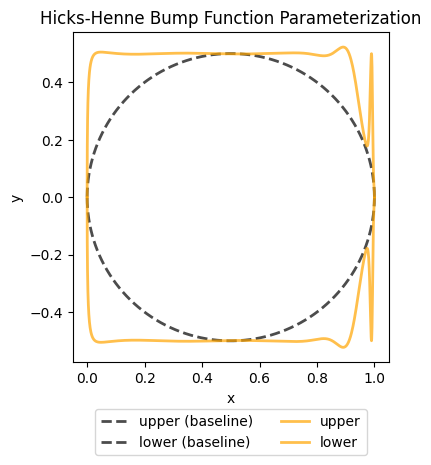

In [5]:
# Visualize the fitted Hicks-Henne shape
fig, ax = hicks_henne.visualize()
plt.tight_layout()
plt.show()

The polynomial-exponential functions are active close to $x = 0$ and therefore we get a better fit
there compared to near $x = 1$ where only the sinusoidal family is active.